### Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd

import numpy as np
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt


from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler, RobustScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### Load data

In [2]:
data = pd.read_csv('./Data/iv_data_nifty.csv')
data.head()

,Unnamed: 0,Datetime,Instrument,Date,Expiry,Time,Price,IV_ITM_5,IV_ITM_4,IV_ITM_3,IV_ITM_2,IV_ITM_1,IV_ATM,IV_OTM_1,IV_OTM_2,IV_OTM_3,IV_OTM_4,IV_OTM_5,Time to Expiry,Market Direction
0,0,2019-02-11 09:15:00,NIFTY,2019-02-11,2019-02-14 15:30:00,09:15:00,10897.85,0.0,0.000000,0.000000,0.000000,17.090847,14.639462,14.452594,15.164853,0.000000,14.916689,0.000000,0.008933,0
1,1,2019-02-11 09:30:00,NIFTY,2019-02-11,2019-02-14 15:30:00,09:30:00,10877.25,0.0,17.603888,0.000000,17.461240,17.464575,14.435774,14.187856,13.861563,0.000000,13.098138,0.000000,0.008904,1
2,2,2019-02-11 09:45:00,NIFTY,2019-02-11,2019-02-14 15:30:00,09:45:00,10883.40,0.0,0.000000,0.000000,16.429088,16.241526,13.489549,0.000000,13.127366,12.460890,12.024439,0.000000,0.008876,0
3,3,2019-02-11 10:00:00,NIFTY,2019-02-11,2019-02-14 15:30:00,10:00:00,10863.35,0.0,0.000000,16.169978,0.000000,15.945147,15.672092,14.698478,14.330040,13.971128,13.240040,12.723871,0.008847,1
4,4,2019-02-11 10:15:00,NIFTY,2019-02-11,2019-02-14 15:30:00,10:15:00,10877.65,0.0,16.206091,0.000000,16.156158,16.045691,14.063999,13.784632,13.332267,0.000000,0.000000,0.000000,0.008818,0


In [7]:
data.dropna(inplace=True)

X = data[['Price']] #iv_data[['IV_ATM']]
y = data[['Market Direction']].values.astype('int')


print('Data and Label', X.shape, y.shape)
# print(y[:5])

Data and Label (32287, 1) (32287, 1)


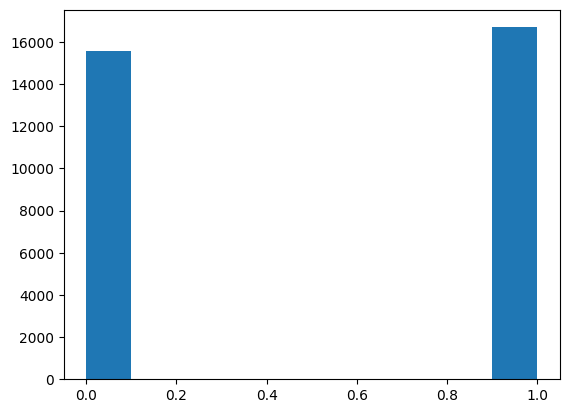

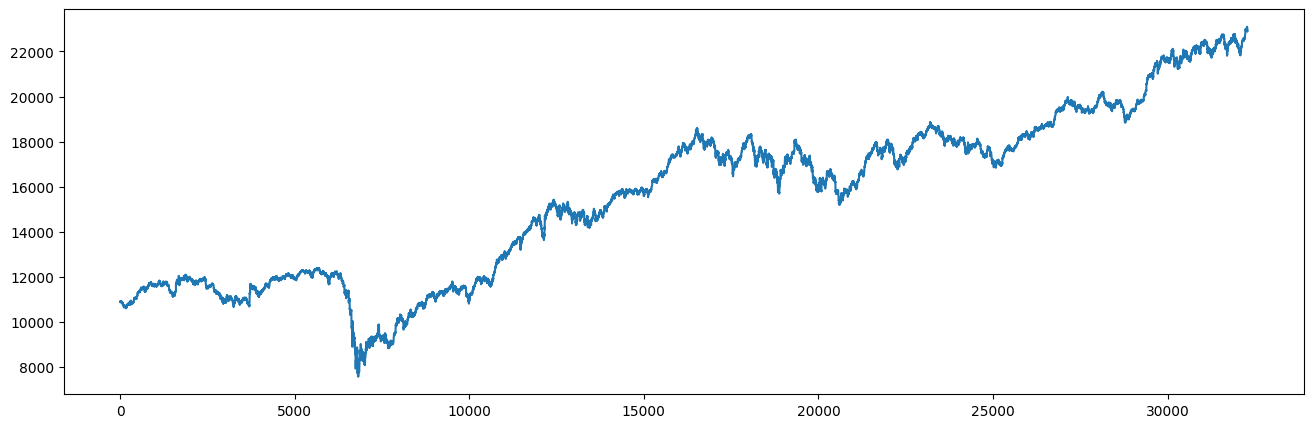

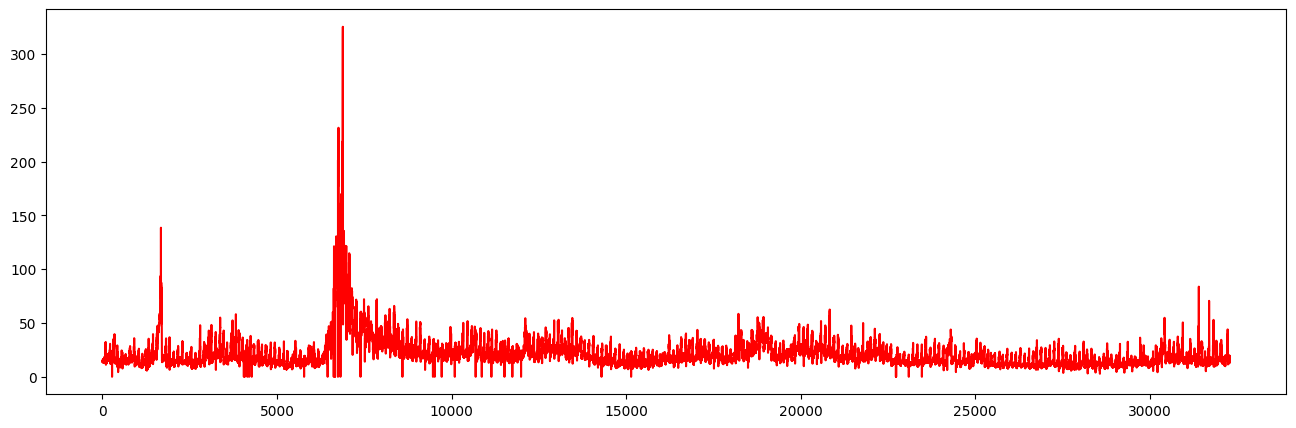

In [14]:
plt.hist(y)
plt.figure(figsize=(16, 5))
plt.plot(X[:])
plt.show()
plt.figure(figsize=(16, 5))
plt.plot(data['IV_ATM'], 'red')
plt.show()

### Train-Test Split

In [15]:
# train-test split for time series
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size


train_X, train_y = X[:train_size], y[:train_size]
test_X, test_y = X[train_size:], y[train_size:]

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(22600, 1) (22600, 1) (9687, 1) (9687, 1)


### Scaling

In [17]:
# scale the data
scaler = MinMaxScaler(feature_range=(0, 1)) # RobustScaler() 
scaler.fit(train_X)

train_X = scaler.transform(train_X)
test_X = scaler.transform(test_X)

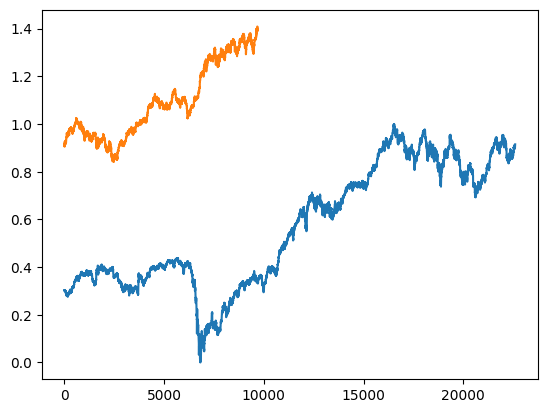

In [19]:
plt.plot(train_X.reshape(-1))
plt.plot(test_X.reshape(-1))

plt.show()

### Dataset

In [28]:
def create_classification_dataset(data, labels, n_lookback, n_forecast=None):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        n_lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(data)-n_lookback): 
        feature = data[i:i+n_lookback]
        # target = dataset[i+1:i+n_lookback+1]
        target = labels[i+n_lookback-1]
        # print(feature.shape, target.shape)
        X.append(feature)
        y.append(target)
    return torch.tensor(X).float(), torch.tensor(y).float()

In [37]:
X_train, y_train = create_classification_dataset(train_X, train_y, n_lookback=30, n_forecast=None)
X_test, y_test = create_classification_dataset(test_X, test_y, n_lookback=30, n_forecast=None)


### LSTM Model

In [64]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x) #self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        # out = self.sigmoid(out)
        # print(out[:5])
        return out

### Dataloaders

In [65]:
# DataLoaders
train_loader = DataLoader(TensorDataset(X_train, y_train), shuffle=True, batch_size=64)
test_loader = DataLoader(TensorDataset(X_test, y_test), shuffle=False, batch_size=1)

### Training

In [68]:
# Parameters
input_size = 1
hidden_size = 256
num_layers = 2
output_size = 1
# batch_size = 32
n_epochs = 100
learning_rate = 0.001


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Model, Loss, Optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
loss_fn = nn.BCEWithLogitsLoss() #nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

## Weight Initialization
# for p in model.parameters():
#     if p.dim() > 1:
#         nn.init.xavier_normal(p)
        
for name, param in model.named_parameters():
  if 'bias' in name:
     nn.init.constant_(param, 0.0)
  elif 'weight' in name:
     nn.init.xavier_normal_(param)

train_losses = []
val_losses = []
# Training Loop
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0
    for i, (X_batch, y_batch) in enumerate(train_loader):
        # print('Batch No: %d' %(i))
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        # print(X_batch.shape, y_batch.shape)
        # print(X_batch[0], y_batch[0])
        # break
        
        optimizer.zero_grad()
        y_pred = model(X_batch)
        # print('Y_pred Y_batch: ', y_pred, y_batch)
        # break
        loss = loss_fn(y_pred, y_batch)
        # print('Loss: ', loss)
        loss.backward()
        # Print the gradients of each layer
        
        # for name, param in model.named_parameters():
        #     if param.grad is not None:
        #         print(f'{name} grad norm: {param.grad.norm().item()}')
                
        # nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient Clipping
        optimizer.step()
        
        epoch_loss += loss.item() #* X_batch.size(0)
    
    epoch_loss /= len(train_loader)
    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_loss:.4f}')
    train_losses.append(epoch_loss)
    
    # Validation
    # model.eval()
    # with torch.no_grad():
    #     val_loss = 0.0
    #     for X_batch, y_batch in test_loader:
    #         X_batch, y_batch = X_batch.to(device), y_batch.to(device)
    #         y_pred = model(X_batch)
    #         # print(y_pred[:5], y_batch[:5])
    #         loss = loss_fn(y_pred, y_batch)
    #         val_loss += loss.item() * X_batch.size(0)
        
    #     val_loss /= len(test_loader)
    #     print(f'Validation Loss: {val_loss:.4f}')
        
    # val_losses.append(val_loss)
    
        
print("Training complete!")

Epoch [1/100], Loss: 0.6931
Epoch [2/100], Loss: 0.6929
Epoch [3/100], Loss: 0.6928
Epoch [4/100], Loss: 0.6928
Epoch [5/100], Loss: 0.6927
Epoch [6/100], Loss: 0.6927
Epoch [7/100], Loss: 0.6927
Epoch [8/100], Loss: 0.6926
Epoch [9/100], Loss: 0.6926
Epoch [10/100], Loss: 0.6926
Epoch [11/100], Loss: 0.6926
Epoch [12/100], Loss: 0.6926
Epoch [13/100], Loss: 0.6926
Epoch [14/100], Loss: 0.6926
Epoch [15/100], Loss: 0.6926
Epoch [16/100], Loss: 0.6926
Epoch [17/100], Loss: 0.6926
Epoch [18/100], Loss: 0.6926
Epoch [19/100], Loss: 0.6926
Epoch [20/100], Loss: 0.6926
Epoch [21/100], Loss: 0.6926
Epoch [22/100], Loss: 0.6926
Epoch [23/100], Loss: 0.6926
Epoch [24/100], Loss: 0.6926
Epoch [25/100], Loss: 0.6926
Epoch [26/100], Loss: 0.6926
Epoch [27/100], Loss: 0.6926
Epoch [28/100], Loss: 0.6926
Epoch [29/100], Loss: 0.6926
Epoch [30/100], Loss: 0.6926
Epoch [31/100], Loss: 0.6926
Epoch [32/100], Loss: 0.6926
Epoch [33/100], Loss: 0.6926
Epoch [34/100], Loss: 0.6926
Epoch [35/100], Loss: 0

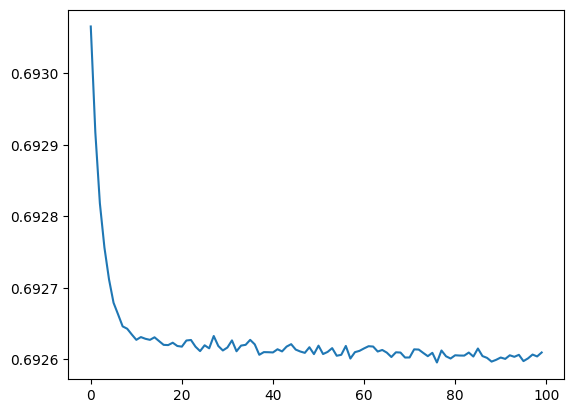

In [69]:
plt.plot(train_losses)

In [57]:
test_loader = DataLoader(TensorDataset(X_test, y_test), shuffle=False, batch_size=1)

In [60]:
model.eval()
with torch.no_grad():
    val_loss = 0.0
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        # print(X_batch, y_batch)
        # break
        y_pred = model(X_batch)
        print('GT %d Pred %d' %(y_batch, y_pred))
        loss = loss_fn(y_pred, y_batch)
        val_loss += loss.item() * X_batch.size(0)
    
    val_loss /= len(test_loader)
    print(f'Validation Loss: {val_loss:.4f}')
        
    # val_losses.append(val_loss)

GT 0 Pred 0
GT 1 Pred 0
GT 1 Pred 0
GT 0 Pred 0
GT 0 Pred 0
GT 1 Pred 0
GT 0 Pred 0
GT 1 Pred 0
GT 1 Pred 0
GT 1 Pred 0
GT 0 Pred 0
GT 0 Pred 0
GT 1 Pred 0
GT 0 Pred 0
GT 0 Pred 0
GT 1 Pred 0
GT 1 Pred 0
GT 1 Pred 0
GT 0 Pred 0
GT 0 Pred 0
GT 1 Pred 0
GT 0 Pred 0
GT 1 Pred 0
GT 1 Pred 0
GT 0 Pred 0
GT 0 Pred 0
GT 1 Pred 0
GT 0 Pred 0
GT 0 Pred 0
GT 0 Pred 0
GT 1 Pred 0
GT 0 Pred 0
GT 1 Pred 0
GT 0 Pred 0
GT 0 Pred 0
GT 1 Pred 0
GT 0 Pred 0
GT 0 Pred 0
GT 1 Pred 0
GT 1 Pred 0
GT 1 Pred 0
GT 1 Pred 0
GT 1 Pred 0
GT 0 Pred 0
GT 1 Pred 0
GT 0 Pred 0
GT 0 Pred 0
GT 0 Pred 0
GT 0 Pred 0
GT 1 Pred 0
GT 0 Pred 0
GT 0 Pred 0
GT 1 Pred 0
GT 0 Pred 0
GT 1 Pred 0
GT 0 Pred 0
GT 1 Pred 0
GT 1 Pred 0
GT 1 Pred 0
GT 0 Pred 0
GT 1 Pred 0
GT 1 Pred 0
GT 0 Pred 0
GT 1 Pred 0
GT 1 Pred 0
GT 1 Pred 0
GT 1 Pred 0
GT 0 Pred 0
GT 0 Pred 0
GT 1 Pred 0
GT 0 Pred 0
GT 0 Pred 0
GT 1 Pred 0
GT 1 Pred 0
GT 1 Pred 0
GT 0 Pred 0
GT 1 Pred 0
GT 0 Pred 0
GT 1 Pred 0
GT 0 Pred 0
GT 1 Pred 0
GT 0 Pred 0
GT 1 Pred 0
GT 0

KeyboardInterrupt: 